In [1]:
from tqdm import tqdm

from utils.data import read_domain_ids_per_chain_from_txt
from utils.dataset import *
from utils.plot import *
from diffusion_model.embed import *
from diffusion_model.structure_diffusion_model import *

In [2]:
# Load data
test_pdbs, test_pdb_chains = read_domain_ids_per_chain_from_txt('./data/test_domains.txt')
test_loader = BackboneCoordsDataLoader(test_pdb_chains, './data/test_backbone_coords_20.npy', './data/test_data_res_20.npy', seq_length=20, batch_size=1, shuffle=False)

# Initialize model
diffusion = ProteinDiffusion()
model = StructureModel()

# Load model
model.load_state_dict(torch.load('./trained_models/structure_model_STATE_FINAL_e50_lr=0.001.pt'))

# test samples
test_samples = ['1acfA', '1bkrA', '1cc8A', '3mx7A']

# Sample structure for four test samples

In [3]:
model.eval()
gt_coords = []
pred_coords = []
for batch, (pdb, res_label, atom_coords) in enumerate(tqdm(test_loader)):
    if pdb[0] in test_samples:
        print(pdb)
        atom_coords = atom_coords.to(torch.float32)
        n_coords = atom_coords[:, :, 0]
        ca_coords = atom_coords[:, :, 1]
        c_coords = atom_coords[:, :, 2]

        single_repr = get_single_representation(pdb, res_label)
        pair_repr = torch.cdist(ca_coords, ca_coords, p=2).to(torch.float32)
        
        x_t = diffusion.sample_p(model, single_repr, pair_repr)
        
        gt_coords.append(ca_coords)
        pred_coords.append(x_t)

  0%|          | 0/4372 [00:00<?, ?it/s]

('1acfA',)


  0%|          | 10/4372 [00:12<1:29:37,  1.23s/it]

('1bkrA',)


  1%|          | 49/4372 [00:17<21:58,  3.28it/s]  

('1cc8A',)


 59%|█████▊    | 2566/4372 [00:23<00:06, 296.78it/s]

('3mx7A',)


100%|██████████| 4372/4372 [00:28<00:00, 151.02it/s]


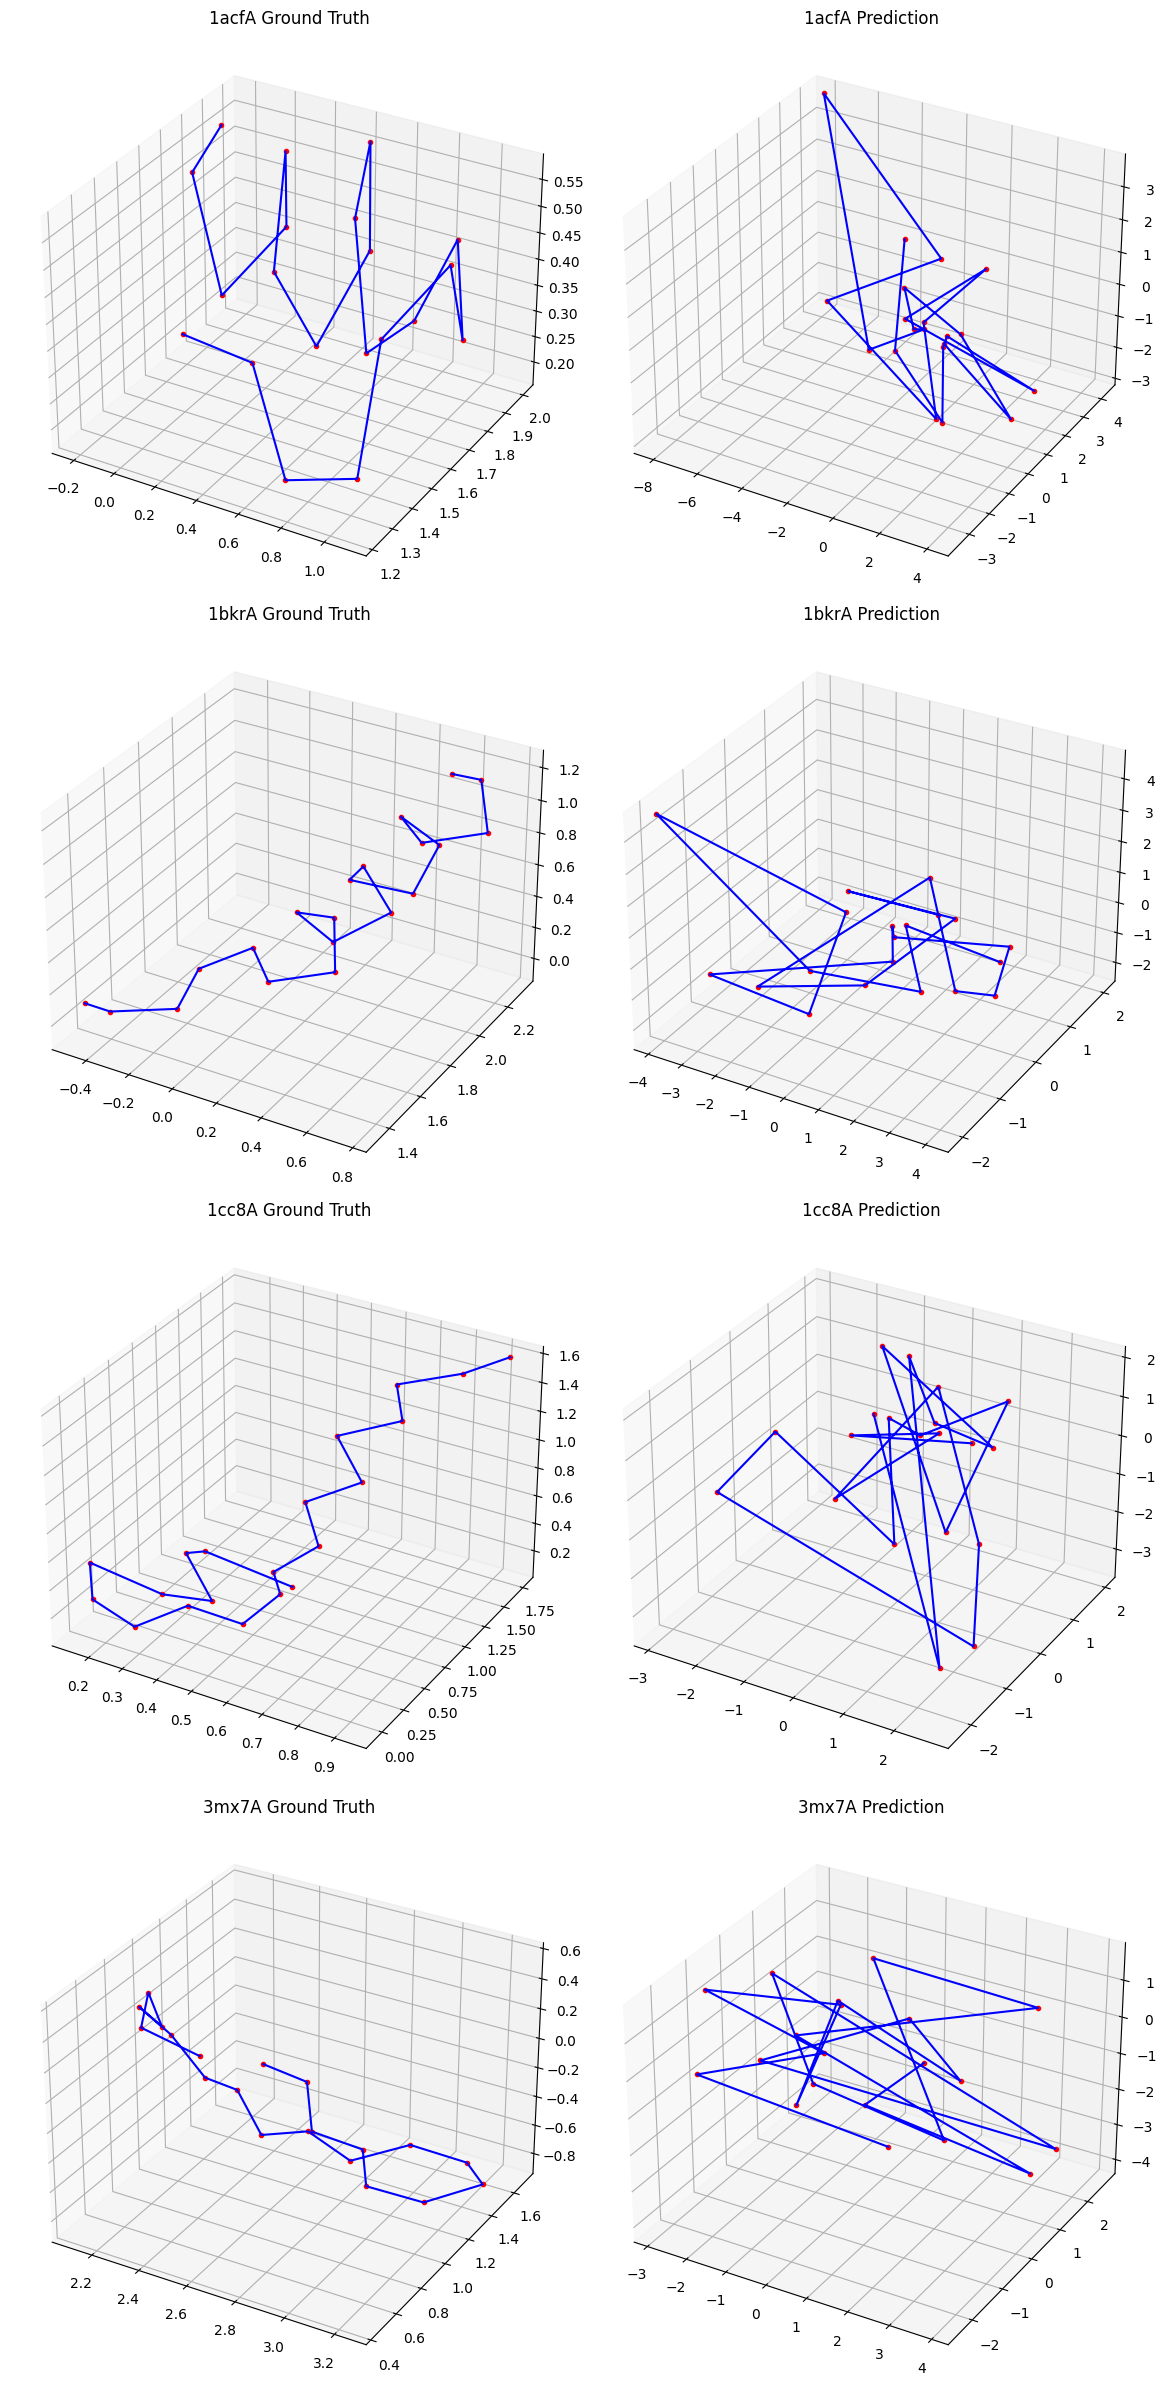

In [4]:
fig = plt.figure(figsize=(12, 24))

for i, (gt, pred) in enumerate(zip(gt_coords, pred_coords)):
    # Ground truth plot
    ax_gt = fig.add_subplot(4, 2, 2*i+1, projection='3d')
    plot_3d_scatter(ax_gt, gt.squeeze(0), f'{test_samples[i]} Ground Truth')
    # Prediction plot
    ax_pred = fig.add_subplot(4, 2, 2*i+2, projection='3d')
    plot_3d_scatter(ax_pred, pred.squeeze(0), f'{test_samples[i]} Prediction')

plt.tight_layout()
plt.show()

# CA-CA distance, bond length, angles distribution

In [6]:
ca_distance_gt = []
ca_n_distance_gt = []
for batch_idx, (pdb, res_label, atom_coords) in enumerate(tqdm(test_loader)):
    atom_coords = atom_coords.to(torch.float32)
    n_coords = atom_coords[:, :, 0]
    ca_coords = atom_coords[:, :, 1]
    c_coords = atom_coords[:, :, 2]

    pair_repr = torch.cdist(ca_coords, ca_coords, p=2).to(torch.float32)
    ca_n_distance = torch.cdist(ca_coords, n_coords, p=2).to(torch.float32)
    
    ca_distance = torch.diagonal(pair_repr.squeeze(0), 1)
    ca_n_distance = torch.diagonal(ca_n_distance.squeeze(0), 1)

    ca_distance_gt.append(ca_distance)
    ca_n_distance_gt.append(ca_n_distance)

ca_distance_gt = torch.cat(ca_distance_gt, dim=0).numpy()
ca_n_distance_gt = torch.cat(ca_n_distance_gt, dim=0).numpy()

100%|██████████| 4372/4372 [00:00<00:00, 7277.70it/s]


In [37]:
test_loader = BackboneCoordsDataLoader(test_pdb_chains, './data/test_backbone_coords_20.npy', './data/test_data_res_20.npy', seq_length=20, batch_size=128, shuffle=False)

ca_distance_pred = []
ca_n_distance_pred = []

for batch_idx, (pdb, res_label, atom_coords) in enumerate(tqdm(test_loader)):
    atom_coords = atom_coords.to(torch.float32)
    n_coords = atom_coords[:, :, 0]
    ca_coords = atom_coords[:, :, 1]
    c_coords = atom_coords[:, :, 2]

    single_repr = get_single_representation(pdb, res_label)
    pair_repr = torch.cdist(ca_coords, ca_coords, p=2).to(torch.float32)

    x_hat = diffusion.sample_p(model, single_repr, pair_repr)
    ca_distance_pred.append(x_hat)

ca_distance_pred = torch.cat(ca_distance_pred, dim=0)
ca_distance_pred = torch.cdist(ca_distance_pred, ca_distance_pred, p=2).to(torch.float32)
ca_distance_pred = torch.diagonal(ca_distance_pred, 1, 1, 2)
ca_distance_pred = ca_distance_pred.reshape(-1)

100%|██████████| 35/35 [17:14<00:00, 29.55s/it]


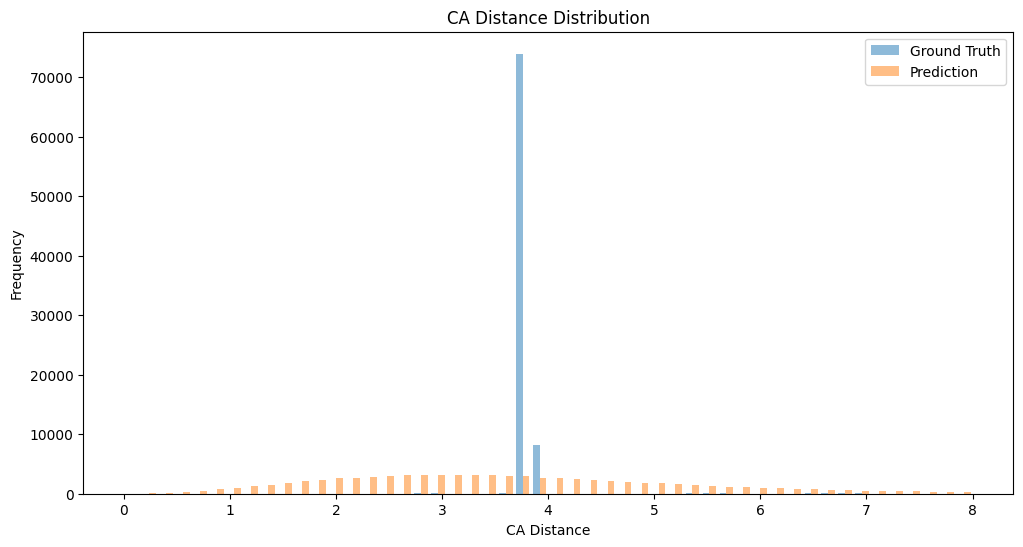

In [48]:
# plot histogram of CA distances
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.hist([ca_distance_gt * 15, ca_distance_pred.detach().numpy()], bins=50, range=[0, 8], alpha=0.5, label=['Ground Truth', 'Prediction'])
ax.set_xlabel('CA Distance')
ax.set_ylabel('Frequency')
ax.set_title('CA Distance Distribution')
ax.legend()
plt.show()